In [129]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
from qiskit_optimization.converters import QuadraticProgramToQubo
from typing import List
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

0 1 0
1 0 1


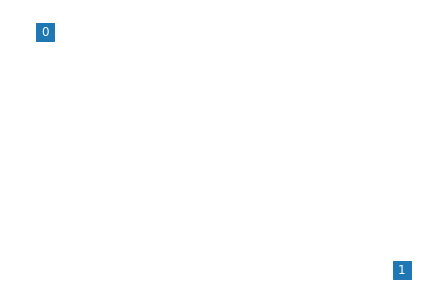

In [151]:
class FSPasTSP:
     """Quantum Optimization for the FSP by mapping it to FSP"""
     def __init__(self,numberMachine : int,procTime:List[List[int]],numberJobs : int)-> None :
        """
        Args : 
        timeSpan : the makespan value
        numberMachine : machine number
        numverJobs : job's number
        """
        self.numberMachine = numberMachine
        self.numberJobs = numberJobs
        self.procTime = procTime

     def convert_FSP_WH(self) -> dict[tuple[int, int], int]:
         """
             We are using Widemar & Hertz approach
             duv=p1,u + \sum_2^m (m-i)|pi,u - pi-1,v| + pmv
         """
         TspInstance={
             (u,v) :
             self.procTime[1][u]
             +self.procTime[self.numberMachine-1][v]
             +sum([(self.numberMachine-i)*abs(self.procTime[i][u]-self.procTime[i-1][v]) for i in range(self.numberMachine)])
             for u in range(self.numberJobs) 
             for v in range(self.numberJobs)
             if u!=v 
             }
         return TspInstance

     def convert_FSP_Gupta(self):
         TspInstance={
             (u,v):
             sum([max(self.procTime[i][u]-self.procTime[i-1][v],0)+2*abs(min(self.procTime[i][u]-self.procTime[i-1][v],0)) for i in range(self.numberMachine)])
             for u in range(self.numberJobs) 
             for v in range(self.numberJobs)
             if u!=v 
             }
         return TspInstance

     def quadratic_program(self)->QuadraticProgram:
         TspIns=self.convert_FSP_WH()
         mdl=Model(name="TSP")
         n=self.numberJobs
         x = {(i, k): mdl.binary_var(name=f"x_{i}_{k}") for i in range(n) for k in range(n)}
         cost_fun=mdl.sum(
             TspIns[(u,v)]* x[(u, k)] * x[(v, (k + 1) % n)]
             for u in range(n)
             for v in range(n)
             for k in range(n)
             if u != v
         )
         mdl.minimize(cost_fun)
         for u in range(n):
            mdl.add_constraint(mdl.sum(x[(u, k)] for k in range(n)) == 1)
         for k in range(n):
            mdl.add_constraint(mdl.sum(x[(u, k)] for u in range(n)) == 1)
         op = from_docplex_mp(mdl)
         return op

     def draw(self):
          instance = self.convert_FSP_WH()
          graph = nx.DiGraph()
          graph.add_nodes_from([i for i in range(self.numberJobs)])
          graph.add_weighted_edges_from(
              (key[0],key[0],str(value)) 
              for value,key in enumerate(instance)
              )
          plt.figure()    
          pos = nx.spring_layout(graph)
          weight_labels = nx.get_edge_attributes(graph,'weight')
          nx.draw(graph,pos,font_color = 'white', node_shape = 's', with_labels = True,)
          nx.draw_networkx_edge_labels(graph,pos,edge_labels=weight_labels)
          '''
          pos = nx.spring_layout(graph, seed=6)
          # nodes
          nx.draw_networkx_nodes(graph, pos, node_size=500)
          # edges
          nx.draw_networkx_edges(
            graph, pos,edgelist=edges,edge_color='b',  width=6,  style="dashed"
           )
          # labels
          nx.draw_networkx_labels(graph, pos, font_size=20, font_family="sans-serif")
          ax = plt.gca()
          ax.margins(0.08)
          plt.axis("off")
          plt.tight_layout()
          plt.show()    
          '''
          
          
     
     def QUBO(self)->QuadraticProgram :
         conv = QuadraticProgramToQubo()
         return conv.convert(self.quadratic_program())

        
fsp = FSPasTSP(2,[[3,5],[5,4]],2)
qubo = fsp.QUBO()
fsp.draw()
i=fsp.convert_FSP_WH()
for ket in enumerate(i) : print(ket[0],ket[1][1],ket[1][0] )       
    



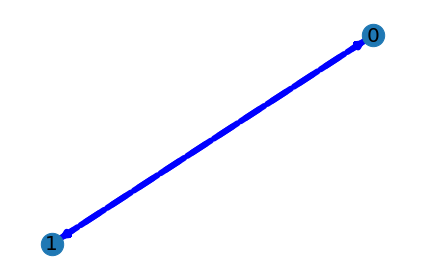

(0, 1) 0
(1, 0) 1
